# Ensemble Analysis for New Hampshire

In [31]:
import json

import matplotlib.pyplot as plt
import networkx as nx
from gerrychain import (Partition, Graph, MarkovChain, proposals, updaters, constraints, accept)
from gerrychain.proposals import recom
from gerrychain.tree import recursive_tree_part, bipartition_tree
from gerrychain.random import random
from functools import partial
import pandas as pd

from rba import constants
from rba.util import (get_num_vra_districts, get_gerrymandering_score,
                      get_district_gerrymandering_scores, get_county_weighted_random_spanning_tree)
from rba.visualization import visualize_partition_geopandas

In [32]:
# CONSTANTS

random.seed(2023)
GEODATA_FILE = "../rba/data/2010/new_hampshire_geodata_merged.json"
COMMUNITY_OUTPUT_FILE = "../rba/data/2010/new_hampshire_communities.json"
VRA_CONFIG_FILE = "vra_nh.json"
NUM_DISTRICTS = 2

In [39]:
# LOADING DATA

with open(GEODATA_FILE, "r") as f:
    data = json.load(f)
nx_graph = nx.readwrite.json_graph.adjacency_graph(data)
graph = Graph.from_networkx(nx_graph)
del nx_graph

with open(COMMUNITY_OUTPUT_FILE, "r") as f:
    community_data = json.load(f)

edge_lifetimes = {}
for edge, lifetime in community_data["edge_lifetimes"].items():
    u = edge.split(",")[0][2:-1]
    v = edge.split(",")[1][2:-2]
    edge_lifetimes[frozenset((u, v))] = lifetime

with open(VRA_CONFIG_FILE, "r") as f:
    vra_config = json.load(f)

vra_threshold = vra_config["opportunity_threshold"]
num_combined_vra_districts = vra_config["combined"]
del vra_config["opportunity_threshold"]

305


In [40]:
# UPDATERS

rba_updaters = {
    "population": updaters.Tally("total_pop", alias="population"),
    # "gerry_score": partial(get_gerrymandering_score, edge_lifetimes=edge_lifetimes),
    # "district_gerry_scores": partial(get_district_gerrymandering_scores, edge_lifetimes=edge_lifetimes)
    "gerry_score": lambda p: 0.5,
    "district_gerry_scores": lambda p: [0.5] * NUM_DISTRICTS
}

vra_updaters = {f"num_{minority}_vra_districts": partial(get_num_vra_districts,
                                                         label=f"total_{minority}",
                                                         threshold=vra_threshold)
                for minority in vra_config.keys()}

rba_updaters.update(vra_updaters)

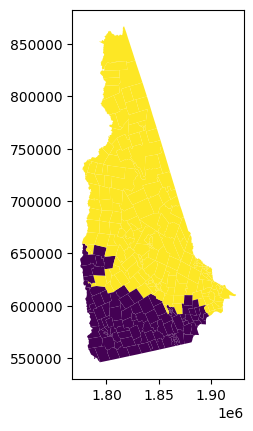

In [41]:
# INITIAL STATE

state_population = 0
for node in graph:
    state_population += graph.nodes[node]["total_pop"]
ideal_population = state_population / NUM_DISTRICTS

initial_assignment = recursive_tree_part(
    graph, range(NUM_DISTRICTS),
    pop_target=ideal_population,
    pop_col="total_pop",
    epsilon=constants.POP_EQUALITY_THRESHOLD)

initial_partition = Partition(graph, initial_assignment, rba_updaters)

visualize_partition_geopandas(initial_partition)

In [42]:
# PROPOSAL METHOD (weighted to prefer county lines)

weighted_recom_proposal = partial(
    recom,
    pop_col="total_pop",
    pop_target=ideal_population,
    epsilon=constants.POP_EQUALITY_THRESHOLD,
    node_repeats=2,
    method=partial(
        bipartition_tree,
        spanning_tree_fn=get_county_weighted_random_spanning_tree)
)

# CONSTRAINTS

# NOTE: we said we wouldn't have a compactness constraint but GerryChain uses one in their example
# showing that maybe it's necessary even for ReCom. This keeps the proposals within 2x the number of
# cut edges in the starting one.
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]),
    2 * len(initial_partition["cut_edges"])
)

pop_constraint = constraints.within_percent_of_ideal_population(initial_partition,
                                                                constants.POP_EQUALITY_THRESHOLD)

vra_constraints = [
    constraints.LowerBound(
        lambda p: p[f"num_{minority}_vra_districts"],
        num_districts
    )
    for minority, num_districts in vra_config.items()]

In [43]:
chain = MarkovChain(
    proposal=weighted_recom_proposal,
    constraints=[
        pop_constraint,
        compactness_bound
    ] + vra_constraints,
    accept=accept.always_accept,
    initial_state=initial_partition,
    total_steps=1000
)

In [44]:
data = pd.DataFrame(
    [sorted(partition["district_gerry_scores"]) + [partition["gerry_score"]]
     for partition in chain.with_progress_bar()],
    columns=[f"district{i}" for i in range(1, NUM_DISTRICTS + 1)] + ["state_gerry_score"]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: 'Key COUNTYFP10 not found'

In [ ]:
plt.hist(data["gerry_score"])
plt.show()